<img src="../assets/LagoDiComo/StarWarsLagoDiComo.jpg" alt="Banner" style="width:100%; max-height:300px; object-fit:cover;"/>

# Monte Carlo 101 — Estimating Lake Como’s area (LLN demo)

**Goal.** Use Monte Carlo to estimate the area of Lake Como from a binary-ish mask (water vs not-water) and show the **Law of Large Numbers**: error shrinks like ~ $1/\sqrt{N}$.

**Estimator.** If we sample $N$ points uniformly in the bounding rectangle (area $A_{\text{box}}$) and $K$ fall in water,
$$
\widehat{A} = A_{\text{box}} \cdot \frac{K}{N},\qquad
\text{SE}(\widehat{A}) \approx A_{\text{box}}\sqrt{\frac{\hat p(1-\hat p)}{N}},
$$
with $\hat p=K/N$. A 95% CI is $\widehat{A}\pm 1.96\,\text{SE}$.

We’ll also compute a **pixel-count reference** area
$$
A_{\text{pix}} = \#\{\text{water pixels}\}\cdot (\text{m/px})^2
$$
to compare MC vs “exact-ish”.


### 📘 Step 1 — Set the real-world scale from the bounding rectangle

**Goal.** Convert your Google Maps measurements (rectangle **width × height** in **km**) into:

* **meters per pixel** (`m_per_px`) so each pixel has a real size, and
* the **real area of the bounding rectangle** $A_{\text{box}}=\text{width}_m\times\text{height}_m$.

**Inputs you fill in the code cell below:**

* `MASK_PATH` → path to your PNG (cyan water on black).
* `BOX_WIDTH_KM`, `BOX_HEIGHT_KM` → the rectangle’s real dimensions (from Google Maps).

**What the code computes:**

* Image size $(W,H)$ in pixels.
* $ \text{m/px}_x=\frac{\text{width}_m}{W}$, $ \text{m/px}_y=\frac{\text{height}_m}{H}$, and a single `m_per_px` (their average—should be \~equal).
* $A_{\text{box}}=\text{width}_m\times\text{height}_m$ in **m²**.

**Why we need this.** In Monte Carlo, the estimator will be

$$
\widehat{A}_{\text{lake}} = A_{\text{box}}\times \frac{\#\{\text{random points in water}\}}{N}.
$$

So we must know $A_{\text{box}}$ in real units.

**Pitfalls / checks**

* Don’t resize the image **after** measuring on Maps.
* If $\text{m/px}_x$ and $\text{m/px}_y$ differ by >\~2%, recheck your rectangle measurements or the screenshot scale.

In [9]:
import matplotlib.image as mpimg

MASK_PATH = "../assets/LagoDiComo/LagoDiComo_after.png"  # your PNG

# ⬇️ Fill these with your Google Maps measurements (in kilometers)
BOX_WIDTH_KM  = 29.01
BOX_HEIGHT_KM = 42.29

# --- compute meters-per-pixel and rectangle area ---
img = mpimg.imread(MASK_PATH)
H, W = img.shape[:2]

width_m  = float(BOX_WIDTH_KM)  * 1000.0
height_m = float(BOX_HEIGHT_KM) * 1000.0

m_per_px_x = width_m  / W
m_per_px_y = height_m / H
m_per_px   = 0.5 * (m_per_px_x + m_per_px_y)  # average (should be almost identical)

A_box = width_m * height_m  # m², real area of the bounding rectangle

print(f"Image size: {W} x {H} px")
print(f"Scale: {m_per_px_x:.6f} m/px (x), {m_per_px_y:.6f} m/px (y) → using {m_per_px:.6f} m/px")
print(f"A_box (bounding rectangle) = {A_box:,.0f} m²")


Image size: 556 x 837 px
Scale: 52.176259 m/px (x), 50.525687 m/px (y) → using 51.350973 m/px
A_box (bounding rectangle) = 1,226,832,900 m²


### 📘 Step 2 — Build a binary **water mask** from the cyan image

**Goal.** Create an indicator function $ \mathbf{1}_{\text{water}}(x,y)$ from your PNG:
**white/True = water**, **black/False = not water**. This is the only thing MC needs to count “inside vs outside”.

**How we do it (brief):**

* Read the RGB image.
* Compute a simple **“cyan score”** (high for water, low for black background).
* Apply a threshold `tau` to get a **Boolean mask**: `mask[y,x] = True` iff pixel is water.

**What you can tweak:**

* `tau` (e.g., 0.15–0.30).

  * If the mask **eats the shoreline** (too strict) → lower `tau`.
  * If it **bleeds into land** (too permissive) → raise `tau`.

**Why not compute pixel area now?**
We don’t have to. The pixel-count area is just a **sanity check**. For the Monte Carlo demo, we only need the mask to test “hit or miss” in the lake.

**Outcome.** After this step you have:

* `mask` (shape H×W, dtype bool) where `True` means “lake”,
* ready to run Monte Carlo: draw random pixel coordinates uniformly in the rectangle and count how many fall where `mask==True`.

**Next.** Step 3 will do **one Monte Carlo estimate**: choose $N$, sample $N$ points uniformly, compute $\widehat{A}$ and a 95% CI.

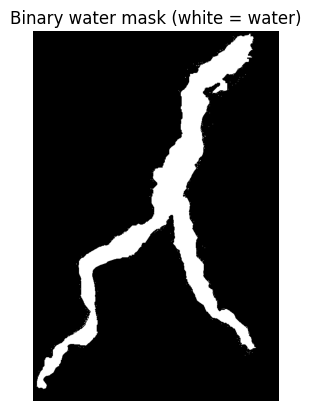

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load image (cyan water on black)
img = mpimg.imread(MASK_PATH)
rgb = img[..., :3]
rgb = rgb / 255.0 if rgb.max() > 1.1 else rgb

# Turn cyan → True (water), black → False (land)
r, g, b = rgb[...,0], rgb[...,1], rgb[...,2]
score = 0.5*(g + b) - 0.2*r   # emphasize cyan, suppress red
tau = 0.20                    # tweak 0.15–0.30 if needed
mask = score > tau            # True = water

# Quick visual check
plt.imshow(mask, cmap="gray")
plt.title("Binary water mask (white = water)")
plt.axis("off")
plt.show()


### 📘 Step 3 — First Monte Carlo estimate (one $N$, hit-or-miss)

**Goal.** Estimate the lake’s area by drawing $N$ points uniformly in the **bounding rectangle** and counting the fraction that land **in water** (given by `mask`).

**Estimator**

$$
\widehat{A} \;=\; A_{\text{box}} \cdot \frac{K}{N}, \qquad \hat p=\frac{K}{N}
$$

where $K$ = number of sampled points falling in water.

**Uncertainty (approx. 95% CI)**

$$
\text{SE}(\widehat{A}) \approx A_{\text{box}} \sqrt{\frac{\hat p(1-\hat p)}{N}}, 
\quad \widehat{A} \pm 1.96\,\text{SE}.
$$

**Inputs expected from previous steps**

* `A_box` (real area of the bounding rectangle, in m²)
* `mask` (boolean array H×W, `True` = water)

**Parameter to choose here:** `N` (number of random points). Error shrinks \~ $1/\sqrt{N}$.

In [11]:
import numpy as np

# --- Prereqs from Steps 1–2 ---
# A_box : float (m^2), mask : np.ndarray[bool] with shape (H, W)
try:
    A_box, mask
except NameError as e:
    raise RuntimeError("Missing variables from previous steps: make sure A_box and mask are defined.") from e

# --- Monte Carlo: single estimate ---
N = 50_000                     # ⬅️ choose N (e.g., 10_000, 50_000, 100_000)
rng = np.random.default_rng(7) # seed for reproducibility

H, W = mask.shape
xs = rng.integers(0, W, size=N)
ys = rng.integers(0, H, size=N)

K = int(mask[ys, xs].sum())
p_hat = K / N
A_hat = A_box * p_hat
SE = A_box * np.sqrt(max(p_hat*(1-p_hat), 0.0) / N)
ci_lo, ci_hi = A_hat - 1.96*SE, A_hat + 1.96*SE

# Display (both m² and km² for intuition)
to_km2 = 1e-6
print(f"N = {N:,} samples")
print(f"Hits in water K = {K:,}  →  p̂ = {p_hat:.5f}")
print(f"A_hat = {A_hat:,.0f} m²  ({A_hat*to_km2:,.3f} km²)")
print(f"SE    = {SE:,.0f} m²  ({SE*to_km2:,.3f} km²)")
print(f"95% CI: [{ci_lo:,.0f},  {ci_hi:,.0f}] m²   "
      f"([{ci_lo*to_km2:,.3f}, {ci_hi*to_km2:,.3f}] km²)")


N = 50,000 samples
Hits in water K = 5,943  →  p̂ = 0.11886
A_hat = 145,821,358 m²  (145.821 km²)
SE    = 1,775,582 m²  (1.776 km²)
95% CI: [142,341,218,  149,301,499] m²   ([142.341, 149.301] km²)


### 📘 Step 4A — Visualize sampled points (inside vs outside)

**Goal.** Sanity-check the hit-or-miss idea: plot a small set of random points over the mask and color them by “water or not”.

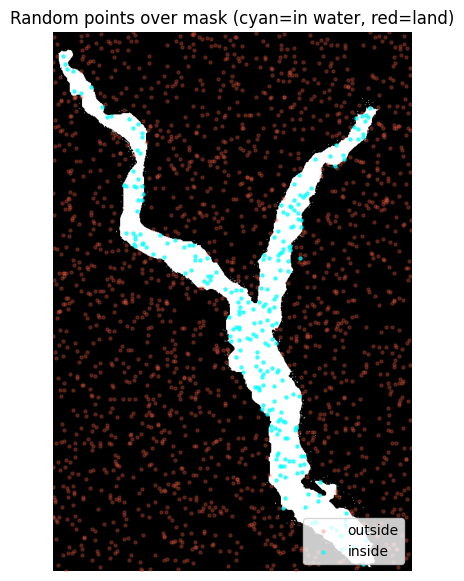

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Prereqs: `mask` from Step 2
try:
    mask
except NameError as e:
    raise RuntimeError("Missing `mask` from Step 2.") from e

H, W = mask.shape
rng = np.random.default_rng(17)
N_vis = 2_000  # small sample just for visualization

xs = rng.integers(0, W, size=N_vis)
ys = rng.integers(0, H, size=N_vis)
inside = mask[ys, xs]

plt.figure(figsize=(5,7))
plt.imshow(mask, cmap="gray")                         # background: lake white, land black
plt.scatter(xs[~inside], ys[~inside], s=5, alpha=0.25, c="tomato", label="outside")
plt.scatter(xs[ inside], ys[ inside], s=5, alpha=0.65, c="cyan",   label="inside")
plt.gca().invert_yaxis()                              # align with image coordinates
plt.title("Random points over mask (cyan=in water, red=land)")
plt.axis("off")
plt.legend(loc="lower right")
plt.show()


### 📘 Step 4B — Convergence: standard error vs $N$ (\~ $1/\sqrt{N}$)

**Goal.** Show Monte Carlo **uncertainty** shrinking as $\sim 1/\sqrt{N}$.
We plot the **standard error (SE)** of $\widehat{A}$ for increasing $N$.
This doesn’t need any “true area”; it uses the binomial variance formula.

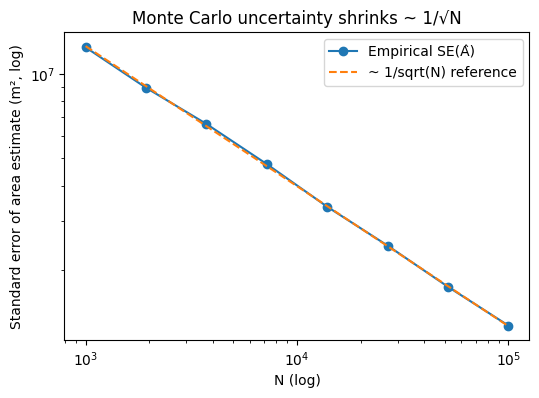

Median hit-rate estimate p~ = 0.1196
SE at N=100,000: ~1,265,059 m²


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Prereqs: `mask` (Step 2) and `A_box` (Step 1)
try:
    mask, A_box
except NameError as e:
    raise RuntimeError("Missing `mask` (Step 2) or `A_box` (Step 1).") from e

H, W = mask.shape
rng = np.random.default_rng(2025)

# Ns to test (feel free to edit)
Ns = np.logspace(3, 5, 8, dtype=int)  # 1e3 ... 1e5
SEs_emp = []
p_hats   = []

for N in Ns:
    xs = rng.integers(0, W, size=N)
    ys = rng.integers(0, H, size=N)
    K  = int(mask[ys, xs].sum())
    p_hat = K / N
    SE = A_box * np.sqrt(max(p_hat*(1 - p_hat), 0.0) / N)
    p_hats.append(p_hat)
    SEs_emp.append(SE)

SEs_emp = np.array(SEs_emp)

# Build a smooth 1/sqrt(N) reference line using a pilot p~ (median p_hat)
p_tilde = float(np.median(p_hats))
SE_ref = A_box * np.sqrt(p_tilde * (1 - p_tilde) / Ns)

plt.figure(figsize=(6,4))
plt.loglog(Ns, SEs_emp, marker="o", label="Empirical SE(Â)")
plt.loglog(Ns, SE_ref, "--", label="~ 1/sqrt(N) reference")
plt.xlabel("N (log)")
plt.ylabel("Standard error of area estimate (m², log)")
plt.title("Monte Carlo uncertainty shrinks ~ 1/√N")
plt.legend()
plt.show()

print(f"Median hit-rate estimate p~ = {p_tilde:.4f}")
print(f"SE at N={Ns[-1]:,}: ~{SEs_emp[-1]:,.0f} m²")

### 📘 Step 5 — Interactive slider (see points, $\hat A$, SE, margin, 95% CI)

**Goal.** Move a slider to change $N$ (number of random points).
We redraw sampled points over the mask (cyan=in water, red=land) and show:

* $\hat A$ (area estimate),
* **SE** (standard error),
* **Margin (±)** = $1.96\times \text{SE}$,
* **95% CI**,
* Comparison to a **reference area** (here we’ll use **146 km²** for Lake Como).

> Note: For speed, we display at most **5,000** points even if $N$ is larger, but all stats use the full $N$.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Prereqs from previous steps ---
try:
    mask, A_box
except NameError as e:
    raise RuntimeError("Missing `mask` (Step 2) or `A_box` (Step 1).") from e

H, W = mask.shape

# --- Reference area (Lake Como) ---
LAKE_TRUE_KM2 = 146.0
LAKE_TRUE_M2  = LAKE_TRUE_KM2 * 1e6

# --- Pre-generate a big pool of random points for consistency & speed ---
N_MAX = 100_000
rng = np.random.default_rng(123)
xs = rng.integers(0, W, size=N_MAX)
ys = rng.integers(0, H, size=N_MAX)
inside = mask[ys, xs]               # boolean array of length N_MAX
cum_hits = np.cumsum(inside.astype(int))

def mc_stats(N: int):
    """Compute K, p_hat, A_hat, SE, CI using first N pre-generated points."""
    if N < 1 or N > N_MAX:
        raise ValueError(f"N must be between 1 and {N_MAX}.")
    K = int(cum_hits[N-1])
    p_hat = K / N
    A_hat = A_box * p_hat
    SE = A_box * np.sqrt(max(p_hat*(1 - p_hat), 0.0) / N)
    CI = (A_hat - 1.96*SE, A_hat + 1.96*SE)
    return K, p_hat, A_hat, SE, CI

# --- Widgets ---
# Discrete values you asked for
N_options = [2_000, 5_000, 10_000, 20_000, 50_000, 100_000]
slider = widgets.SelectionSlider(
    options=N_options, value=2_000, description="N", continuous_update=False
)
stats_html = widgets.HTML(layout=widgets.Layout(width="420px"))
out_fig = widgets.Output()

def update_plot(change=None):
    N = slider.value
    K, p_hat, A_hat, SE, (lo, hi) = mc_stats(N)
    margin = 1.96 * SE
    diff = A_hat - LAKE_TRUE_M2
    to_km2 = 1e-6

    # Update stats block
    stats_html.value = f"""
    <pre style="font-size:12px; line-height:1.25em">
    N = {N:,}
    Hits in water K = {K:,}   →   p̂ = {p_hat:.5f}
    A_hat = {A_hat:,.0f} m²  ({A_hat*to_km2:,.3f} km²)
    SE     = {SE:,.0f} m²  ({SE*to_km2:,.3f} km²)
    Margin (±) = {margin:,.0f} m²  ({margin*to_km2:,.3f} km²)
    95% CI  = [{lo:,.0f}, {hi:,.0f}] m²   ([{lo*to_km2:,.3f}, {hi*to_km2:,.3f}] km²)

    Reference (Lake Como) = {LAKE_TRUE_M2:,.0f} m² ({LAKE_TRUE_KM2:.3f} km²)
    Difference (A_hat - ref) = {diff:,.0f} m² ({diff*to_km2:,.3f} km²)
    </pre>
    """

    # Redraw figure
    with out_fig:
        clear_output(wait=True)
        plt.figure(figsize=(5,7))
        plt.imshow(mask, cmap="gray")
        # show at most 5k points for speed
        n_show = min(N, 5_000)
        show_idx = np.arange(n_show)
        x_show = xs[show_idx]
        y_show = ys[show_idx]
        in_show = inside[show_idx]
        plt.scatter(x_show[~in_show], y_show[~in_show], s=5, alpha=0.25, c="tomato", label="land")
        plt.scatter(x_show[ in_show], y_show[ in_show], s=5, alpha=0.65, c="cyan",   label="water")
        plt.gca().invert_yaxis()
        plt.axis("off")
        plt.title(f"Random points (cyan=in water, red=land) — N={N:,}")
        plt.legend(loc="lower right")
        plt.show()

# Hook up events and show UI
slider.observe(update_plot, names="value")
update_plot()  # initial render
display(widgets.HBox([widgets.VBox([slider, stats_html]), out_fig]))
